<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import multiprocessing as mp
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11149

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1970-01-02,0
1970-01-05,0
1970-01-06,0
1970-01-07,0
1970-01-08,0


In [6]:
states.state.value_counts()

0    3228
2    2519
5    2416
4    2146
1    1476
6     912
3     672
Name: state, dtype: int64

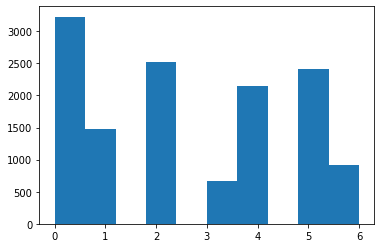

In [7]:
plt.hist(states.state);

In [8]:
TRIM = 0.02
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6]

In [9]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

0

In [10]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [11]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 112


In [12]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(1973, 1, 12),
 datetime.date(2022, 12, 31),
 datetime.date(2013, 1, 2),
 2)

In [13]:
START, TODAY

(datetime.date(1973, 1, 12), datetime.date(2022, 12, 31))

In [14]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [15]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [16]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [17]:
def filter_by_min_price(data):
    for col in data.columns:
        if (data[col][data[col].notnull()].to_numpy()[-1]
            < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [18]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [19]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [20]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [21]:
def trim_returns(returns, trim):
    lower_q = trim / 2
    upper_q = 1 - lower_q
    qs = np.quantile(returns, q=[lower_q, upper_q])
    returns = returns[((returns > qs[0]) & (returns < qs[1]))]
    return returns

In [22]:
def get_annualized_daily_return(returns, trim=0.02):
    returns = np.array([1] + list((returns[returns.notnull()] + 1).to_numpy()))
    if trim:
        returns = trim_returns(returns, trim)
    amt = returns.cumprod()
    n = len(returns)
    if n > 2:
        daily_return = amt[-1]**(1/max(n - 1, 1))
    else:
        daily_return = 0
    return daily_return

In [23]:
def get_daily_annualized_return_by_state(data, trim=0.02):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        annualized_daily_return = get_annualized_daily_return(returns)
        stock_data.append(annualized_daily_return)
        for state in STATES:
            daily_annualized_return_state = get_annualized_daily_return(
                returns[data.state == state], trim=trim)
            stock_data.append(daily_annualized_return_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['dar'] + [f'dar_{state}' for state in STATES],
        index=stocks)
    return df_out

In [24]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [25]:
def process_batch(batch, min_start, trim=0.02):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    #state_sharpes = get_sharpes_by_state(data)
    #return state_sharpes
    state_dars = get_daily_annualized_return_by_state(data, trim)
    return state_dars

In [26]:
# TODO: multiprocess
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACEL ADUS AGTC ALGS AMK APAC ARES ASTC AUY AZZ BCTF BHK BLL BOXL BSX BZC CBB CDE CFK CIFR CLPT CNL CPAK CRTD CTRA CXH DCNT DIAX DOW DUKB ECOM ELBO ENTX ESP EXAC FCEL FHB FMN FRME FTW GCO GHIX GMRK GRND GWW HDTV HLNE HRMY HYSL IDTI IMMU INVO ISR JE JWN KLXE KVHI LENB LMAT LSPN MANT MDC MGAM MLAB MORF MSNQ MXC NBXZ NFLD NN NSCN NVG OBLG OMN OSAT PAQC PDSN PHAT PLTR PPSI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_73511/1541653759.py:5: RuntimeWarning: divide by zero encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1
/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_73511/1541653759.py:5: RuntimeWarning: invalid value encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1


PSNY PZE RAPT REST RMED RSG SAJA SCMM SFSF SINO SMMF SOLO SRAX STIX SWAG TAYD TETC TKR TPGH TSAT TXCO UMRX UXJ VIFL VOXW VVX WFII WPG XAN XWEL ZKID 

In [29]:
df = pd.concat(dfs, axis=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
A,1.000236,0.997679,1.001119,0.000000,1.001331,1.001412,1.002142,1.014798
AA,1.000363,0.997416,1.001310,1.001616,1.000222,1.001154,1.001260,1.000111
AAIC,0.999343,0.997510,1.000160,0.000000,1.002091,1.000987,1.000340,1.010203
AAL,0.999847,0.995503,1.002215,0.000000,1.001521,1.000538,1.001417,1.015366
AAME,0.999725,0.997470,1.000591,1.001011,1.002013,1.000087,1.000161,1.002075


In [38]:
df.tail()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
ZTEK,1.000154,0.998997,0.997307,0.000000,1.004410,1.002845,0.999696,1.005021
ZTR,1.000334,0.999379,1.000587,1.001687,1.001010,1.000475,1.000806,1.000934
ZUMZ,1.000239,0.997552,1.001392,0.000000,1.002521,1.000535,1.001184,1.010381
ZWS,1.000393,0.996886,1.000329,0.000000,1.000860,1.001419,1.001657,1.017919
ZYXI,1.000768,1.000697,1.001624,0.000000,1.002207,0.997893,1.001790,1.020395


In [39]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [30]:
df = pd.read_csv('../data/sharpes_by_state.csv', index_col=0)

In [31]:
CURRENT_STATE# = 0

0

In [32]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
#df['weighted'] = {
#    0: 0.6*df.sharpe_0 + 0.4*df.sharpe_1,
#    1: 0.2*df.sharpe_0 + 0.6*df.sharpe_1 + 0.2 * df.sharpe_2
#}[CURRENT_STATE]


if CURRENT_STATE == 0:
    df['weighted'] = (
        0.8*df[f'dar_{CURRENT_STATE}'] 
        + 0.2*df[f'dar_{CURRENT_STATE + 1}'])
elif CURRENT_STATE == 1:
    df['weighted'] = (
        0.6*df[f'dar_{CURRENT_STATE}']
        + 0.2*df[f'dar_{CURRENT_STATE + 1}']
        + 0.2*df[f'dar_{CURRENT_STATE - 1}'])
#elif CURRENT_STATE == ...
elif CURRENT_STATE == 7:
    df['weighted'] = (
        0.8*df[f'dar_{CURRENT_STATE}']
        + 0.2*df[f'dar_{CURRENT_STATE - 1}'])
df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
OMQS,0.999151,1.000952,1.004683,0.0,0.996359,0.995341,0.998177,0.985834,1.001698
GCBC,1.000643,1.001057,1.000232,0.0,1.000433,1.000236,1.000723,0.996728,1.000892
ZYXI,1.000768,1.000697,1.001624,0.0,1.002207,0.997893,1.001790,1.020395,1.000882
LFMD,1.000486,1.000608,1.001195,0.0,1.007828,0.996705,0.999593,0.962088,1.000726
FNV,1.000673,1.000589,1.001155,0.0,1.000660,1.001051,1.000211,0.997582,1.000702


In [33]:
df.mean(), df.median()

(dar         1.000128
 dar_0       0.998269
 dar_1       1.000584
 dar_2       0.283379
 dar_3       1.000918
 dar_4       1.000881
 dar_5       1.000925
 dar_6       0.997750
 weighted    0.998732
 dtype: float64,
 dar         1.000283
 dar_0       0.998491
 dar_1       1.000684
 dar_2       0.000000
 dar_3       1.000900
 dar_4       1.000954
 dar_5       1.000953
 dar_6       1.004767
 weighted    0.998954
 dtype: float64)

In [34]:
always_exclude = ['EP', 'NXN', 'NXP']
exclude = {
    0: ['AGNC', 'CGAU', 'CTSH', 'HMY', 'MRTI', 'OMQS', 'ORLY', 'UTHR', 'ZYXI'], 
    1: [],
    7: []}

In [35]:
best_weighted = [
    s for s in df.index
    if s not in exclude[CURRENT_STATE] + always_exclude
][:20]

In [36]:
print(sorted(best_weighted))
#sorted(best_weighted)

['AGI', 'CEF', 'CFFN', 'CZFS', 'DGX', 'FCN', 'FNV', 'GCBC', 'GUT', 'IEI', 'IIM', 'KSM', 'LFMD', 'MIN', 'MIY', 'MMU', 'MTA', 'NAZ', 'NEN', 'NPV']


In [37]:
DOLLAR_AMT = 100_000
FRAC_IN = 0.583
current = df.loc[best_weighted]
current['w'] = (current.weighted - 1) 
current.w = current.w / current.w.sum()
current['amt'] = (DOLLAR_AMT * FRAC_IN * current.w).round().astype(int)
current

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted,w,amt
GCBC,1.000643,1.001057,1.000232,0.000000,1.000433,1.000236,1.000723,0.996728,1.000892,0.126954,7401
LFMD,1.000486,1.000608,1.001195,0.000000,1.007828,0.996705,0.999593,0.962088,1.000726,0.103288,6022
FNV,1.000673,1.000589,1.001155,0.000000,1.000660,1.001051,1.000211,0.997582,1.000702,0.099970,5828
DGX,1.000671,1.000416,1.000499,0.000000,1.001183,1.000924,1.000841,1.005054,1.000433,0.061569,3589
MTA,1.000311,1.000509,1.000088,0.000000,1.003847,1.000604,0.999504,0.989606,1.000425,0.060421,3523
CZFS,1.000405,1.000357,1.000615,0.000000,0.999825,1.000224,1.000406,1.003491,1.000409,0.058217,3394
NEN,1.000598,1.000364,1.000412,1.000627,1.000908,1.000476,1.001242,0.996226,1.000374,0.053199,3101
CEF,1.000155,1.000359,1.000138,1.000524,0.999818,1.000370,0.999846,0.999576,1.000315,0.044836,2614
FCN,1.000736,1.000380,1.000041,0.000000,1.001826,1.001370,1.001138,1.013691,1.000312,0.044412,2589
AGI,1.000543,1.000364,0.999915,0.000000,1.002067,1.001746,0.999990,0.996778,1.000274,0.039040,2276


In [38]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [68]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,AGI,CEF,CFFN,CZFS,DGX,FCN,FNV,GCBC,GUT,IEI,IIM,KSM,LFMD,MIN,MIY,MMU,MTA,NAZ,NEN,NPV
Date,,,,,,,,,,,,,,,,,,,,
2022-12-23,9.99,17.820000,8.60,77.720001,156.309998,156.889999,135.850006,65.400002,7.39,115.559998,11.92,8.14,2.05,2.79,11.06,10.03,5.15,11.30,71.480003,11.27
2022-12-27,10.29,17.969999,8.69,78.599998,157.279999,159.529999,138.789993,59.099998,7.38,115.019997,11.79,8.08,1.97,2.76,10.97,9.98,5.15,11.21,71.000000,11.08
2022-12-28,10.06,17.760000,8.58,76.400002,156.509995,158.729996,136.770004,55.919998,7.33,114.940002,11.84,8.14,1.82,2.76,10.97,10.01,4.95,11.22,71.000000,10.90
2022-12-29,10.11,17.860001,8.69,76.699997,156.789993,159.330002,136.710007,57.470001,7.47,115.150002,11.91,8.16,1.88,2.76,11.09,10.12,4.90,11.26,70.540001,11.01
2022-12-30,10.11,17.930000,8.65,76.720001,156.440002,158.800003,136.479996,57.419998,7.51,114.889999,12.05,8.17,1.94,2.76,11.09,10.07,4.91,11.16,71.000000,11.16


In [69]:
data = pd.concat([data, states], axis=1)

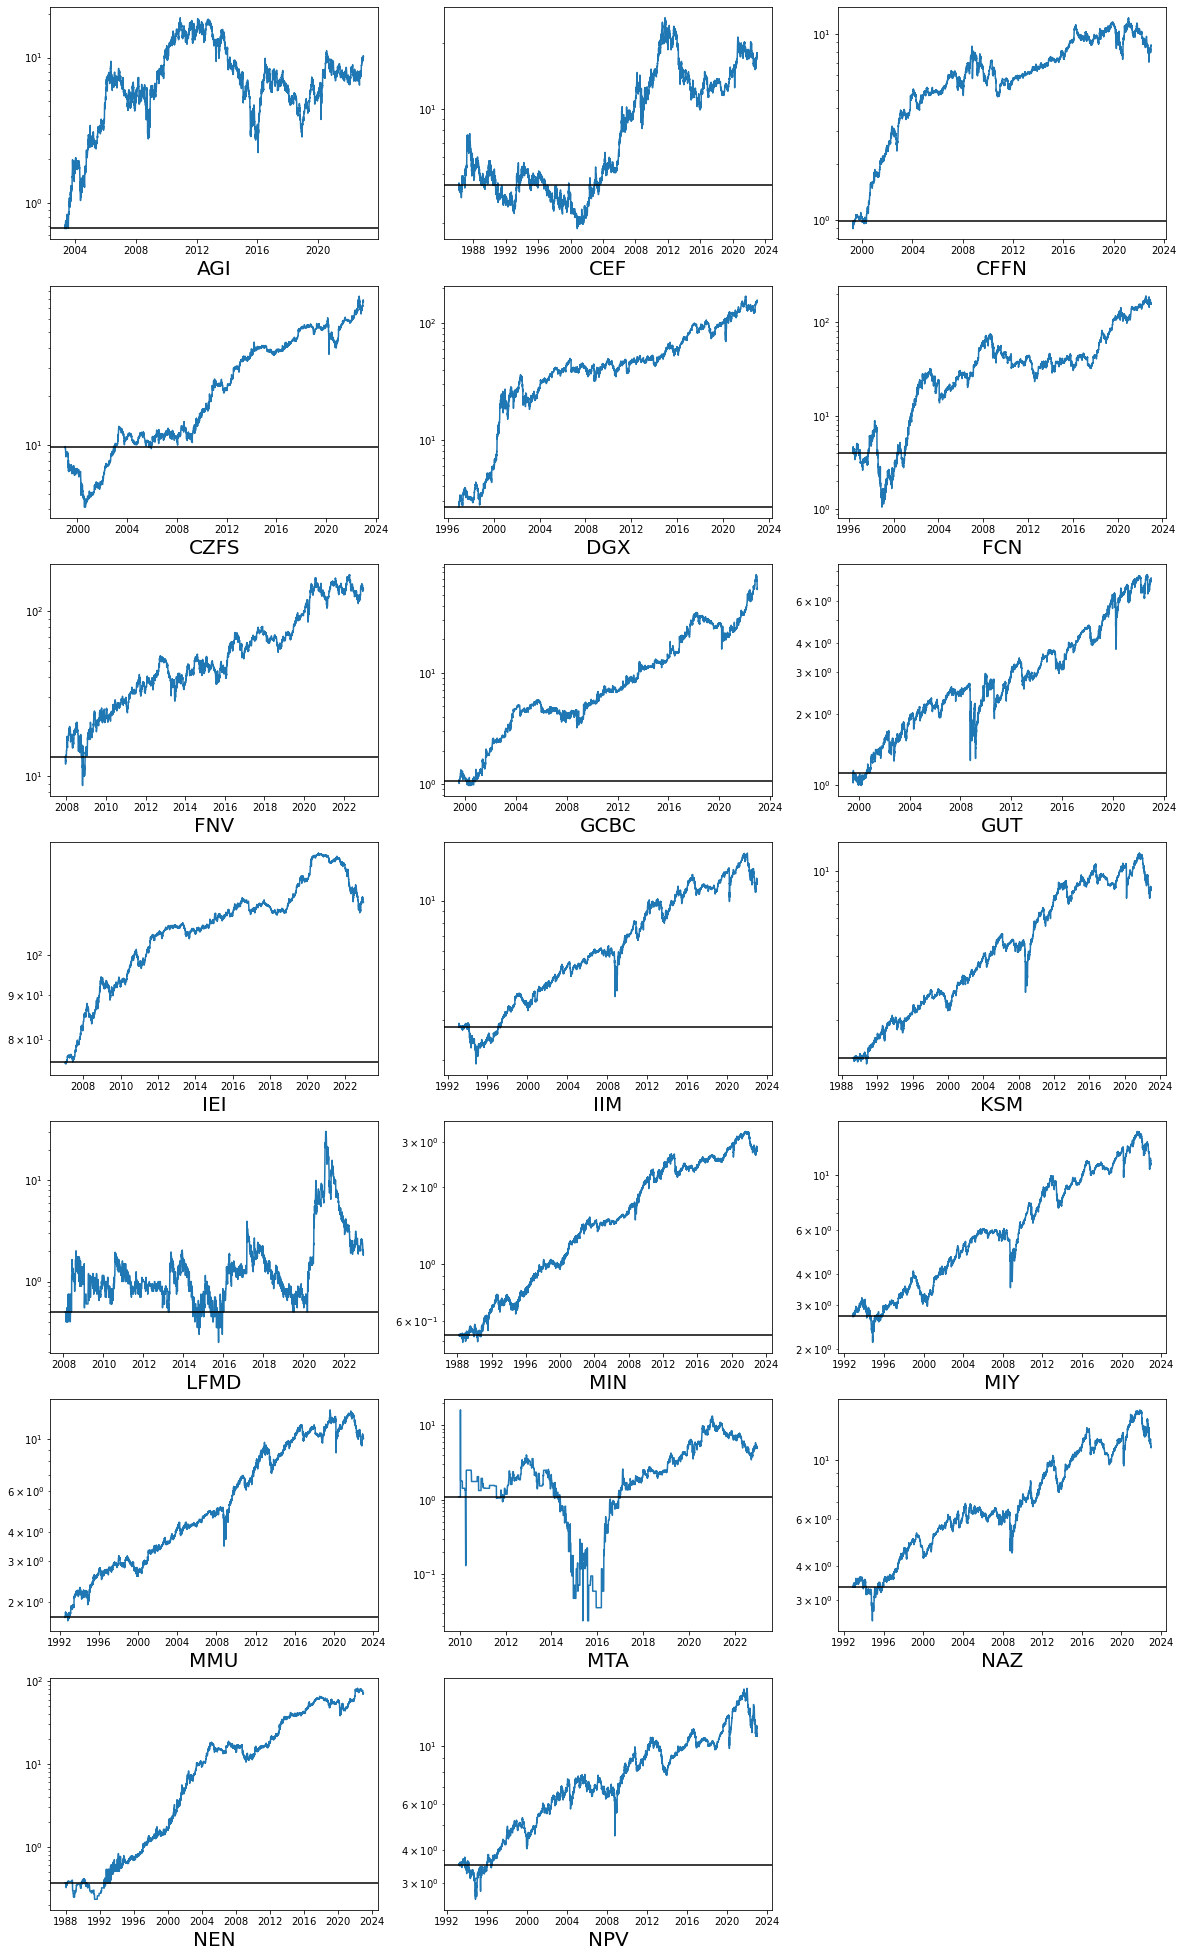

In [70]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    x = data[sym]
    x = x[x.notnull()]
    plt.subplot(7, 3, i + 1)
    plt.plot(x)
    plt.axhline(y=x[0], color='k')
    plt.xlabel(sym)
    plt.yscale('log');

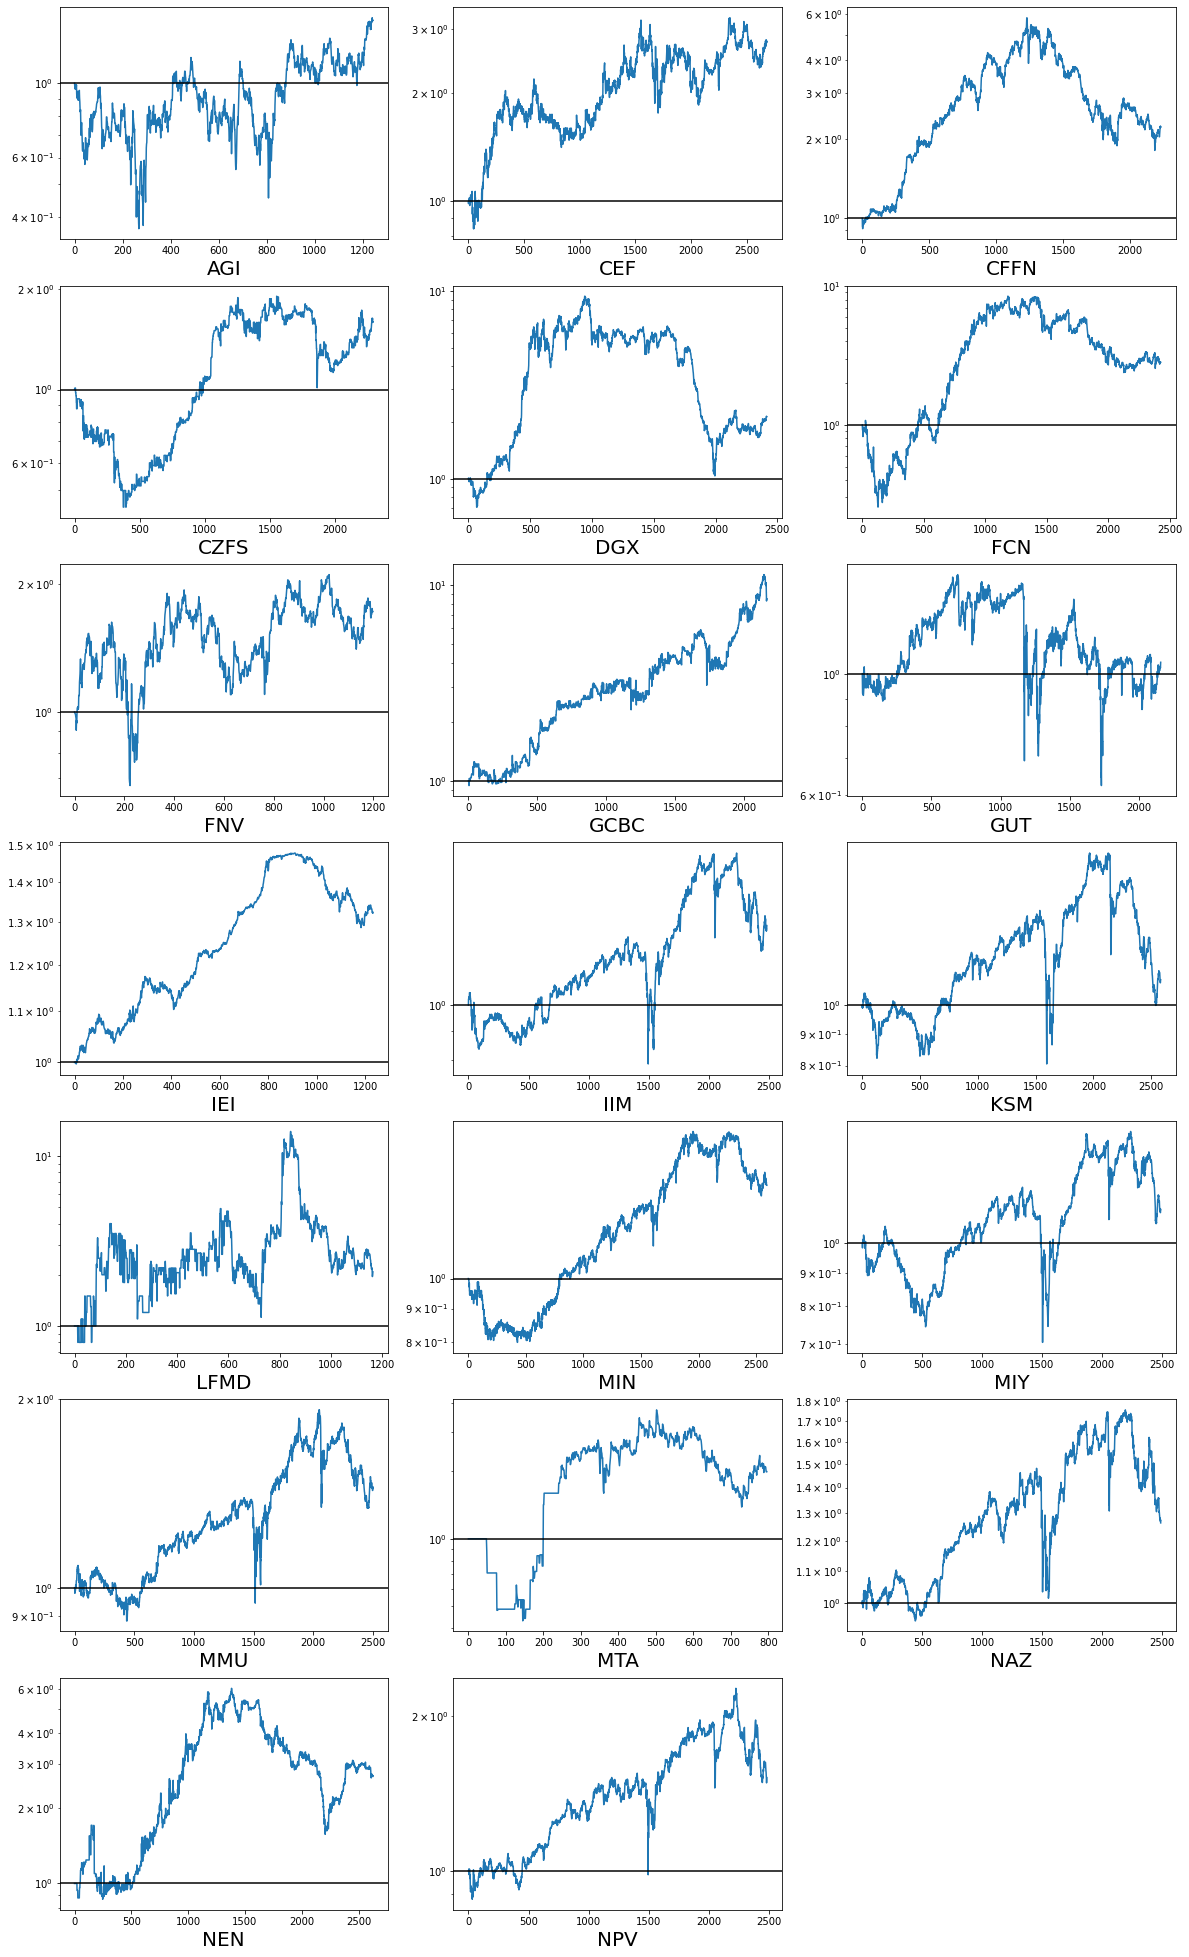

In [71]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.axhline(y=dr[0], color='k')
    plt.yscale('log')
    plt.xlabel(sym);